# Lyft Bikes Renting Trend Analysis

## Investigation Overview

In this investigation, I wanted to look at the characteristics user and locations that could be used to predict renting duration. 

## Dataset Overview

The data consisted attributes of users of approximately 1.2 millions Lyft renting records from January 2019 to June 2019. The attributes include user type, gender, start and end station locations ... etc. 68k datapoints are removed during the analysis because of missing values or inconsistencies.

## Assumptions 
- People older than 100 years old won't use this service 
- People rent bikes more than 8 hours are outliers and does not fit the goal of this analysis

In [13]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [56]:
# load in the dataset into a pandas dataframe
df_bike_1 = pd.read_csv('201901-fordgobike-tripdata.csv',)
df_bike_2 = pd.read_csv('201902-fordgobike-tripdata.csv')
df_bike_3 = pd.read_csv('201903-fordgobike-tripdata.csv')
df_bike_4 = pd.read_csv('201904-fordgobike-tripdata.csv')
df_bike_5 = pd.read_csv('201905-baywheels-tripdata.csv')
df_bike_6 = pd.read_csv('201906-baywheels-tripdata.csv')

df_bike = df_bike_1.append(df_bike_2,sort=False)\
            .append(df_bike_3,sort=False)\
            .append(df_bike_4,sort=False)\
            .append(df_bike_5,sort=False)\
            .append(df_bike_6,sort=False)

In [57]:
# convert user_type, member_gender, and bike_share_for_all_trip into categorical types
var_dict = {'user_type': ['Subscriber','Customer'],
                    'member_gender': ['Male', 'Female'],
                    'bike_share_for_all_trip': ['No','Yes']}

for var in var_dict:
    new_var = pd.api.types.CategoricalDtype(ordered = False,
                                                categories = var_dict[var])
    df_bike[var] = df_bike[var].astype(new_var)

In [58]:
# data wrangling, removing diamonds with inconsistent or missing data.
df_bike.start_time = pd.to_datetime(df_bike['start_time'])
df_bike.end_time = pd.to_datetime(df_bike['end_time'])

df_bike.start_station_id = df_bike.start_station_id.fillna(0)
df_bike.start_station_id = df_bike.start_station_id.astype('int64')
df_bike.end_station_id = df_bike.end_station_id.fillna(0)
df_bike.end_station_id = df_bike.end_station_id.astype('int64')

p = df_bike.member_birth_year.isna().sum()/df_bike.member_birth_year.shape[0]
#print('{0:.2f} % of member birth years are missing. We can delete these data for the analysis.'.format(p*100))
df_bike = df_bike[df_bike.member_birth_year.isna()==False]
#df_bike.shape

df_bike.member_birth_year = df_bike.member_birth_year.astype('int64')

p = df_bike.rental_access_method.isna().sum()/df_bike.rental_access_method.shape[0]
#print("{0:.2f} % of rental access method are missing. We don't use this feature for further analysis. I will delete this column.".format(p*100))
df_bike.drop(columns = ['rental_access_method'], inplace = True)

df_bike = df_bike[(df_bike['start_station_name']!='SF Test Station')&(df_bike['end_station_name']!='SF Test Station')]

[df_bike['start_month'],df_bike['start_day'], df_bike['start_hr'],df_bike['day_of_week']] = \
        [df_bike.start_time.map(lambda x: x.strftime('%m')),\
          df_bike.start_time.map(lambda x: x.strftime('%d')), \
          df_bike.start_time.map(lambda x: x.strftime('%H')), \
          df_bike['start_time'].map(lambda x: x.strftime('%A'))]

[df_bike['end_month'],df_bike['end_day'], df_bike['end_hr']] = \
        [df_bike.end_time.map(lambda x: x.strftime('%m')),\
          df_bike.end_time.map(lambda x: x.strftime('%d')), \
          df_bike.end_time.map(lambda x: x.strftime('%H'))]

df_bike['location'] = pd.cut(df_bike.start_station_longitude,[-125,-122.35, -122.1,-120], labels = ['San Francisco','Oakland', 'San Jose'], include_lowest=True)

df_bike = df_bike[df_bike.member_birth_year>1919]

df_bike= df_bike[df_bike.duration_sec < 28800]

new_var = pd.api.types.CategoricalDtype(ordered = True,
                                            categories = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
df_bike['day_of_week'] = df_bike['day_of_week'].astype(new_var)

label = ['1935-1940','1941-1945','1946-1950','1951-1955','1956-1960','1961-1965','1966-1970','1971-1975','1976-1980',
        '1981-1985','1986-1990','1991-1995','1996-2000','2001-2005']
df_bike['age_group'] = pd.cut(df_bike.member_birth_year, np.arange(1935,2010,5), labels = label, include_lowest=True)

## Distribution of Renting Durations

Renting durations in the dataset take on a very large range of values, from about 60 seconds at the lowest, to about 80000 seconds at the highest. Plotted on a logarithmic scale, the distribution of renting duration is normal distributed with center around 600 seconds.

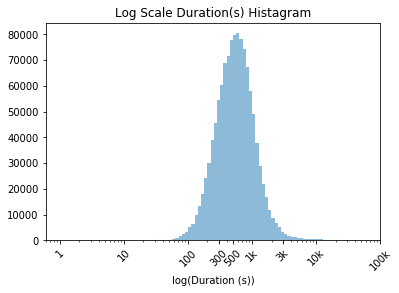

In [28]:
log_binsize = 0.05
bins = 10**np.arange(0,np.log10(df_bike['duration_sec'].max())+log_binsize, log_binsize);

plt.hist(data = df_bike, x = 'duration_sec', bins = bins, color=sb.color_palette()[0],alpha = 0.5);
plt.xscale('log')
plt.xticks([1, 10, 100, 300, 500, 1000, 3000, 10000, 100000],
           ['1', '10', '100', '300', '500', '1k', '3k', '10k','100k'],
          rotation = 45)
plt.xlabel('log(Duration (s))')
plt.title('Log Scale Duration(s) Histagram')
plt.show()

## Distribution of User Ages

People born in 1976 to 1995 use Lyft bikes the most.

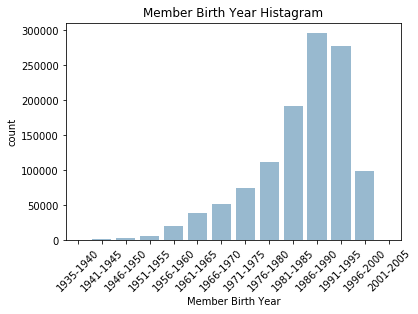

In [61]:
sb.countplot(data = df_bike, x = 'age_group', color = sb.color_palette()[0],alpha = 0.5);
plt.xticks( rotation=45)
plt.xlabel('Member Birth Year')
plt.title('Member Birth Year Histagram')
plt.show()

## Rent Duration vs. User Type and Gender 
Since rent duration varies a lot. I used log scale in the plot to represent it.

- Customers rent bikes longer than subscribers. The mean of subscriber renting time is 500 seconds and the mean of customer renting time is around 800 seconds.
- Female rent bikes slightly longer than male. The mean of female renting time is 600 seconds and the mean of male renting time is around 500 seconds.

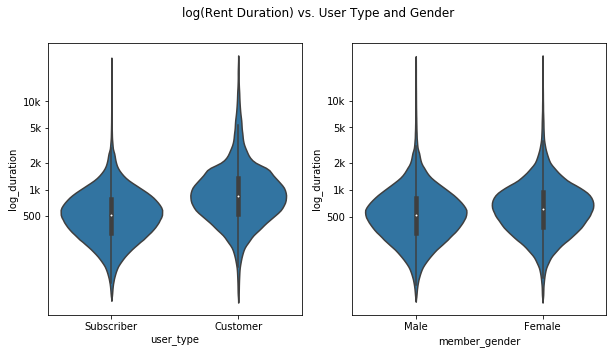

In [40]:
#define numerical and categorical variables
numeric_vars = ['duration_sec', 'start_station_id', 'start_station_latitude', 'start_station_longitude',\
                'end_station_latitude', 'end_station_longitude','end_station_id','bike_id', 'member_birth_year',\
               'start_month','start_day','start_hr','end_month','end_day','end_hr']
categoric_vars = ['start_station_name', 'end_station_name', 'user_type','member_gender','bike_share_for_all_trip']

#temp = df_bike[df_bike.duration_sec < 28800]
df_bike['log_duration'] = np.log10(df_bike.duration_sec)
default_color = sb.color_palette()[0]

fig, ax = plt.subplots(ncols = 2, nrows = 1 , figsize = [10,5])
plt.suptitle('log(Rent Duration) vs. User Type and Gender')
for i in range(2):
    var = categoric_vars[i+2]
    sb.violinplot(data = df_bike, x = var, y = 'log_duration', ax = ax[i],
               color = default_color)
    ax[i].set_yticks(np.log10(np.array([500, 1e3, 2e3, 5e3, 1e4])))
    ax[i].set_yticklabels([500, '1k', '2k', '5k', '10k'])

plt.show()

## Rent Duration, Frequency and Total Rent Time in Day of Week

It's interesting that rent duration is much higher during weekends, but rental frequency is higher during weekdays. Summing up total renting time, we found bike utilization is higher during weekdays.


In [49]:
e = df_bike.groupby('day_of_week').duration_sec.mean()
e = pd.DataFrame(e)
pre_heat_e = pd.pivot_table(e, columns = 'day_of_week',values = 'duration_sec')
pre_heat_e.sort_index(axis=0, ascending=True, inplace=True)
f = df_bike.groupby('day_of_week').duration_sec.count()
f = pd.DataFrame(f)
pre_heat_f = pd.pivot_table(f, columns = 'day_of_week',values = 'duration_sec')
pre_heat_f.sort_index(axis=0, ascending=True, inplace=True)

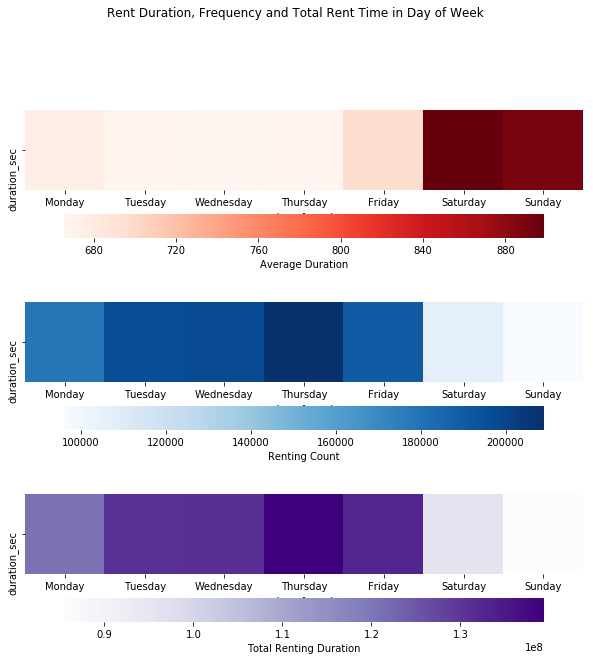

In [53]:
plt.figure(figsize = (10,10))
plt.suptitle('Rent Duration, Frequency and Total Rent Time in Day of Week')
plt.subplot(3,1,1)
sb.heatmap(pre_heat_e, cmap = 'Reds',cbar_kws={'label':'Average Duration',"orientation": "horizontal"},square = True)
plt.subplot(3,1,2)
sb.heatmap(pre_heat_f, cmap = 'Blues', cbar_kws = {'label':'Renting Count',"orientation": "horizontal"},square = True)
plt.subplot(3,1,3)
sb.heatmap(np.transpose(e*f), cmap = 'Purples', cbar_kws={'label': 'Total Renting Duration','orientation':'horizontal'},square = True)
plt.show()

## Rent Duration of User Cities, Genders and Types in Day of Week

Renting time is San Francisco is much longer than other areas. All location has the same renting duration peak during weekends. Female use Lyft bikes more frequent than male and customers rent bikes for longer time no matter which day of the week.

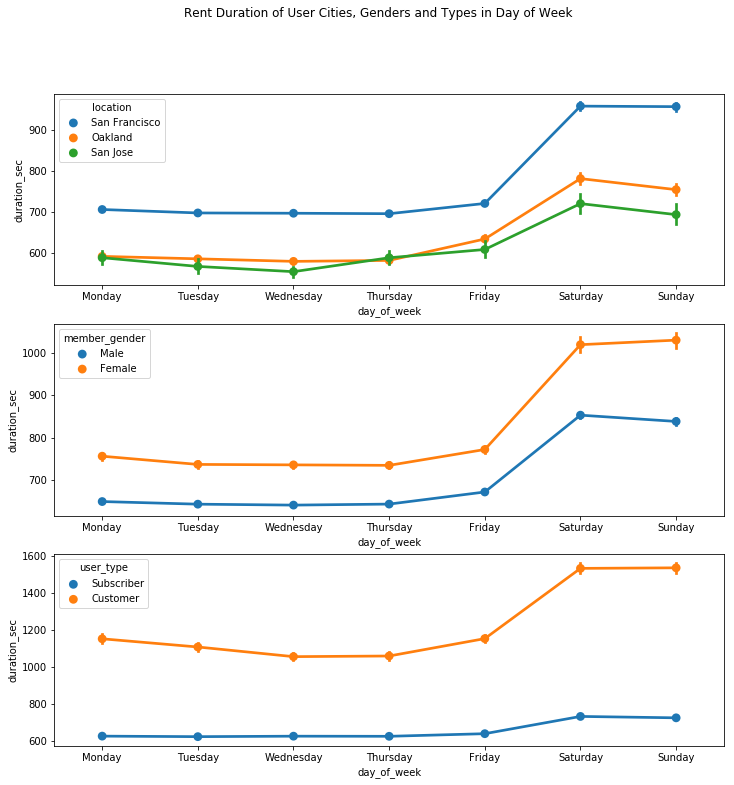

In [55]:
fig, ax = plt.subplots(ncols = 1, nrows = 3, figsize = [12,12])
plt.suptitle('Rent Duration of User Cities, Genders and Types in Day of Week')
sb.pointplot(data=df_bike, x = 'day_of_week',y= 'duration_sec', hue = 'location',ax = ax[0])
sb.pointplot(data=df_bike, x = 'day_of_week',y= 'duration_sec', hue = 'member_gender',ax = ax[1])
sb.pointplot(data=df_bike, x = 'day_of_week',y= 'duration_sec', hue = 'user_type', ax=ax[2])

plt.show();

## User Age, gender and Start Station Distribution in Three Cities 

Overall, the quantity of females renting Lyft bikes is lower than male. There are more Lyft bike stations and more bikes frequently be used used in San Francisco than Oakland and the least popular area is San Jose. Young generation use Lyft bikes more frequently in all cities. (Sine there are too many data points, I only sampled 1000 point for this plot.)

<Figure size 1440x1440 with 0 Axes>

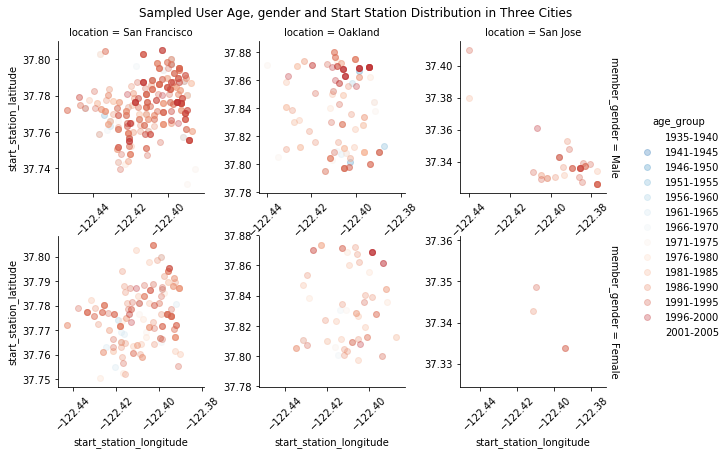

In [77]:
plt.figure(figsize = (20,20));
temp1 = df_bike.sample(1000);
g = sb.FacetGrid(data = temp1,col = 'location', row = 'member_gender',
                 hue = 'age_group',palette="RdBu_r",
                  margin_titles=True, sharey=False,sharex = False);
g.map(plt.scatter, 'start_station_longitude','start_station_latitude',alpha = 0.3).add_legend();
axes = g.axes;
g.set_xticklabels(rotation = 45);
plt.subplots_adjust(top=0.9);
g.fig.suptitle('Sampled User Age, gender and Start Station Distribution in Three Cities ');
plt.show();